In [1]:
#imports of package used in the 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [2]:
X_train=pd.read_csv("X_train.csv",sep=';',index_col="Id") #_sqprice for price per square feet
y_train=pd.read_csv("y_train.csv",sep=';',index_col="Id")
#X_test=pd.read_csv("X_test.csv",sep=';',index_col="Id")
X_train_split1, X_test, y_train_split1, y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=42)

In [3]:
#a function to evaluate the fit (rmse) of the prediciton
from sklearn.metrics import mean_squared_error
def evaluate_fit(y_test,predictions):
    rmse=np.sqrt(mean_squared_error(y_test,predictions))
    return rmse

In [5]:
#necessary imports: decisiontreeregressor, np,pandas, train_test_split
def ensemble_fct(random_state=42,n=20,test_size=0.2,max_features=None,max_depth=6,report_mse=False):
    """This function draws subsamples of the training set, trains a tree to every subsample and generates an
    ensembles of these trees
    
    +++++parameters+++++
    random_state: [None or any integer]
    n: [int] specifies how many subsamples/trees should be used
    test_size: [float (0,1)] - specifies the proportion of the training data should be used as subsample
    max_features:[int or float(0,1)] specifies how many features should be considered at splits. this is used in random forest methods 
    to decorrelate trees
    max_depth: [int] - specifies the maximum depth of the single trees
    report_mse: reports the mse of every single predictors and every ensemble
    """
    
    # drawing randomly 'n' random states from (0,2000)
    states=[]
    while len(states)<n:
        candidate=np.random.randint(0,2000)
        if candidate not in states:
            states.append(candidate)
    print("generated "+str(n)+" random states")
    
    #initialize the tree with the prespecified parameters and define a dataframe to store the forecasts of every tree
    dtree=DecisionTreeRegressor(random_state=random_state,max_depth=max_depth,max_features=max_features) #max_features=80 
    all_predictions=pd.DataFrame(index=X_test.index)
    
    #drawing n subsamples each time from tull training dataset, fitting a tree to the subsample
    #    and use the tree to make prediction for every tree
    for i in range(n):
        X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train_split1,y_train_split1, test_size=test_size,random_state=states[i])
        dtree.fit(X_train_split, y_train_split)
        all_predictions[str(i)]=dtree.predict(X_test)
    
    #evaluate the fit of single tree predictions, returning contains all output variables for further use
    returning={}
    mse_tree=[]
    for i in range(len(states)):
        mse_t=evaluate_fit(y_test,all_predictions[str(i)])
        mse_tree.append(mse_t)
        if report_mse==True:
            print(str(i)+". Tree: "+str(mse_t))
    returning["mse_tree"]=mse_tree
    print("generated "+str(n)+" predictions")
    
    # combine the individual predictions to n ensembles (first ensemble is just single tree)
    ensemble=pd.DataFrame(index=X_test.index)
    labels=list(all_predictions.columns.values)
    ensemble["Ensemble0"]=(all_predictions["0"])
    for i in range(1,len(labels)):
        ensemble["Ensemble"+labels[i]]=ensemble["Ensemble"+str(i-1)]+all_predictions[labels[i]]
    
    #divide the ensembles by the number of trees used for the ensemble predictions
    ensemble_labels=list(ensemble.columns.values)
    counter=1
    for i in ensemble_labels:
        ensemble[i]=ensemble[i]/counter
        counter+=1
    print("generated "+str(n)+" ensembles")
    
    #evaluate the fit of ensembles
    mse_ensemble=[]
    for i in ensemble.columns.values:
        mse_e=evaluate_fit(y_test,ensemble[str(i)])
        if report_mse==True:
            print(i+": "+str(mse_e))
        mse_ensemble.append(mse_e)
        
    #return a dictionary with all the relevant outputs for further use    
    returning["mse_ensemble"]=mse_ensemble
    returning["trees"]=all_predictions
    returning["ensemble"]=ensemble
    returning["states"]=states
    
    
    return returning

generated 100 random states
generated 100 predictions
generated 100 ensembles
min rmse of ensemble prediction: 37683.9688999, number of predictors: 0


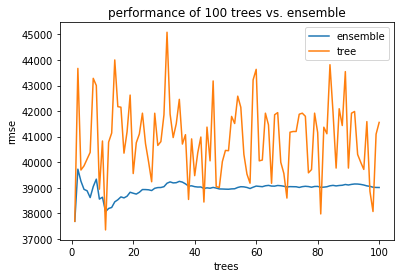

minimum of rmse:37683.9688999


In [13]:
# call the function and specify the parameters
output=ensemble_fct(random_state=42,n=100,test_size=1,max_depth=12);

#unpack the returned parameters
rmse_tree=output["mse_tree"]
rmse_ensemble=output["mse_ensemble"]
trees=output["trees"]
ensemble=output["ensemble"]
states=output["states"]
# print the minimum rmse of all ensembles and the number of trees used
print("min rmse of ensemble prediction: "+str(min(rmse_ensemble))+", number of predictors: "+str(rmse_ensemble.index(min(rmse_ensemble))))

##visualization of the performance of simple ensemble and the individual trees

plt.plot(range(1,len(rmse_tree)+1),rmse_ensemble,label="ensemble")
plt.plot(range(1,len(rmse_tree)+1),rmse_tree, label="tree")
plt.ylabel("rmse")
plt.xlabel("trees")
plt.legend()
plt.title("performance of "+str(len(rmse_tree))+" trees vs. ensemble")
rmse_min = min(rmse_ensemble)

#to visualize the local minimum in the graph
#xpos = rmse_ensemble.index(rmse_min)
#xmin = range(1,len(rmse_tree)+1)[xpos]
#plt.annotate('min', xy=(xmin, rmse_min-15), xytext=(xmin, rmse_min+50),arrowprops=dict(facecolor='black', shrink=0.05))

#to save the figure, specify name.png
#plt.savefig("sqrm_ensemble_"+str(len(rmse_tree))+"_corr_performance.png")
plt.show()
print("minimum of rmse:"+str(rmse_min))

In [21]:
#necessary imports: decisiontreeregressor, np,pandas, train_test_split

def ensemble_weights_fct(random_state=42,n=50,test_size=0.2,max_features=None,max_depth=8,report_mse=False,split_states=None,print_updates=True):
    """
    a function to generate ensembles with higher weights to presumably better predicitons
    function takes the same parameters as normal ensemble fct.
    print_updates: reports everytime a weighted ensemble is generated successfully

    """
    #generate n random states
    
    #check whether random states for the splits are given or whether they need to be generated, and generate if necessary
    if split_states==None:
        split_states=[]
        while len(split_states)<n:
            candidate=np.random.randint(0,2000)
            if candidate not in split_states:
                split_states.append(candidate)
    else:
        split_states=split_states
        
    #check if there is a random state for every n subsample (otherwise function breaks)
    if n>len(split_states):
        raise NameError("the length of split_states has to match n")

    #subsample the training dataset, fit a tree to every subsample, predict and evaluate the 
    #   subsampling-fit as basis for the weights and later use the test set to make actual predictions for each subsample
    dtree=DecisionTreeRegressor(random_state=random_state,max_depth=max_depth,max_features=max_features) #max_features=80 
    all_predictions=pd.DataFrame(index=X_test.index)
    weights=[]
    mse_total=[]
    inverse_mse=[]
    for i in range(n):
        X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train_split1,y_train_split1, test_size=test_size,random_state=split_states[i])
        dtree.fit(X_train_split, y_train_split)
        all_predictions[str(i)]=dtree.predict(X_test)
        weight_eval=dtree.predict(X_eval)
        fit=evaluate_fit(y_eval,weight_eval)
        mse_total.append(fit)
        inverse_mse.append(1/(fit*fit))

    #compute the relative weights for each predictor and apply weights to predictors
    total=sum(inverse_mse)
    for i in inverse_mse:
        weights.append(i/total)
    labels=list(all_predictions.columns.values)
    counter=0
    for i in labels:
        all_predictions[i]=all_predictions[i]*weights[counter]
        counter+=1
        
    #calculate the ensemble dataset by adding all weighted predictors
    
    ensemble=pd.DataFrame(index=X_test.index)
    ensemble["Ensemble"]=all_predictions["0"]
    for i in labels[1:]:
        ensemble["Ensemble"]=(ensemble["Ensemble"]+all_predictions[i])
    #evaluate the fit of the ensemble and return the fit
    if print_updates==True:
        print("generated ensemble from  "+str(n)+" weighted trees")
    return evaluate_fit(y_test,ensemble["Ensemble"])

In [22]:
def ensemble_compare(n=40,random_state=None,test_size=0.2,max_depth=8,max_features=None,print_updates=False):
    """
    a function to compare the ensemble methods, with the same random states (generated in first ensemble)
    and visualize the performance in a graph
    
    parameters are the same as in the simple ensemble fct.
    
    
    """
    # generate predictions from a simple ensemble and return the random states used
    output=ensemble_fct(random_state=random_state,n=n,test_size=test_size,max_depth=max_depth,max_features=max_features);
    rmse_tree=output["mse_tree"]
    rmse_ensemble=output["mse_ensemble"]
    trees=output["trees"]
    ensemble=output["ensemble"]
    states=output["states"]
    #n=output["n"]
    print("min rmse of prediction: "+str(min(rmse_ensemble))+" number of predictors: "+str(rmse_ensemble.index(min(rmse_ensemble))))

    mse_weighted=[]
    mse_tree=[]
    compare_states=[]
    #initialize the tree regressor
    dtree=DecisionTreeRegressor(random_state=random_state,max_depth=max_depth,max_features=max_features)
    
    #generate n weighted ensembles and make a list of the performance each step
    for i in range(0,n):
        compare_states.append(states[i])
        mse_weighted.append(ensemble_weights_fct(n=i+1,max_features=max_features,split_states=states,random_state=random_state,test_size=test_size,max_depth=max_depth,print_updates=print_updates))
        X_train_split, X_eval, y_train_split, y_eval = train_test_split(X_train_split1,y_train_split1, test_size=test_size,random_state=states[i-1])
        dtree.fit(X_train_split, y_train_split)
        prediction=dtree.predict(X_test)
        mse_tree.append(evaluate_fit(y_test,prediction))
        
    # visualize the performance of the single trees and ensemble methods, and save the graphic
    plt.plot(range(1,len(mse_tree)+1),rmse_tree,label="single trees")
    plt.plot(range(1,len(mse_tree)+1),mse_weighted,label="weighted ensemble")
    plt.plot(range(1,len(rmse_tree)+1),rmse_ensemble,label="simple ensemble")
    plt.ylabel("rmse")
    plt.xlabel("trees")
    plt.legend()
    plt.title("performance of tree methods with "+str(len(mse_tree))+" trees")
    rmse_simple_min = min(rmse_ensemble)
    rmse_weighted_min = min(mse_weighted)
    # to save the graphic: plt.savefig("sqrm_comparison_ensem_"+str(n)+"trees_depth"+str(max_depth)+".png")
    plt.show()
    print("minimum rmse simple: "+str(rmse_simple_min))
    print("minimum rmse weighted: "+str(rmse_weighted_min))

generated 20 random states
generated 20 predictions
generated 20 ensembles
min rmse of prediction: 29146.2455922 number of predictors: 19


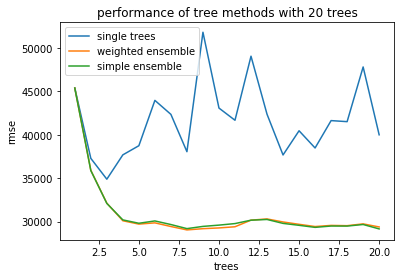

minimum rmse simple: 29146.2455922
minimum rmse weighted: 29030.0538136


In [23]:
ensemble_compare(n=20,random_state=42,test_size=0.4,max_depth=12,print_updates=False)